In [58]:
import tensorflow as tf
import matplotlib.pyplot as plt
from IPython.display import HTML
import numpy as np
from keras import models, layers
from sklearn.metrics import classification_report, f1_score

In [59]:
BATCH_SIZE = 32
IMAGE_SIZE = 256
CHANNELS = 3
EPOCHS = 50
INPUT_SHAPE = (IMAGE_SIZE, IMAGE_SIZE, CHANNELS)
CLASS_NAMES = ['Crack detected', 'Pothole', 'Surface erosion']
N_CLASSES = len(CLASS_NAMES)

In [60]:
dataset = tf.keras.preprocessing.image_dataset_from_directory(
    'E:\Python\Data Science\Road Damage\pothole_detection_CNN\Datasets',
    shuffle = True,
    image_size = (IMAGE_SIZE, IMAGE_SIZE),
    batch_size = BATCH_SIZE
)

Found 1470 files belonging to 3 classes.


In [61]:
class_names = dataset.class_names
class_names

['Crack', 'Pothole', 'Surface Erosion']

In [62]:
len(dataset)

46

In [63]:
for image_batch, label_batch in dataset.take(1):
    print(image_batch.shape)
    print(label_batch.numpy())

(32, 256, 256, 3)
[1 0 1 1 2 1 1 0 2 1 0 0 1 1 0 0 2 0 0 1 0 2 0 1 2 0 2 0 2 1 1 2]


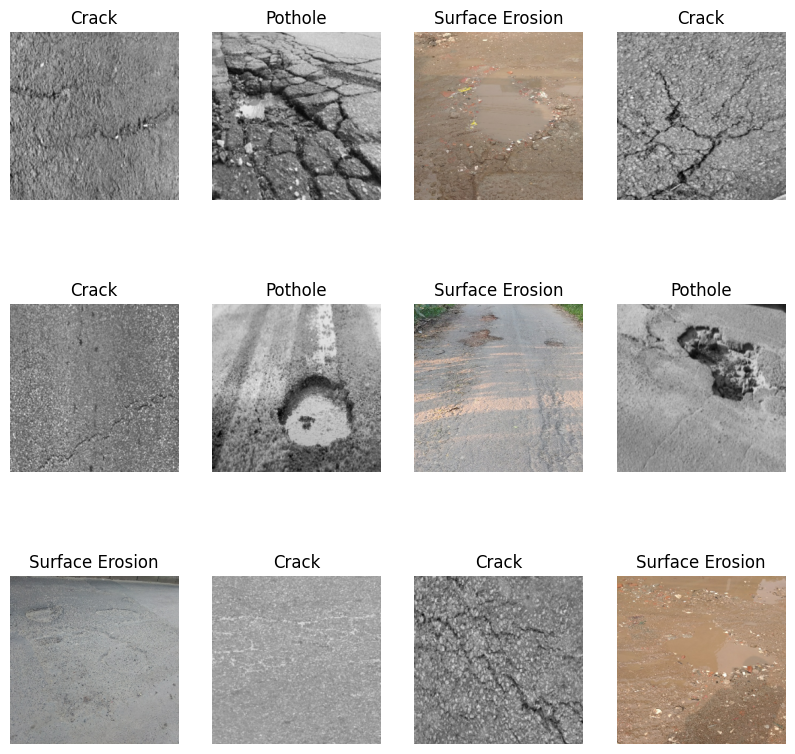

In [64]:
plt.figure(figsize=(10,10))
for image_batch, label_batch in dataset.take(1):
    for i in range(12):
        ax = plt.subplot(3, 4, i+1)
        plt.imshow(image_batch[i].numpy().astype('uint8'))
        plt.title(class_names[label_batch[i]])
        plt.axis('off')

In [ ]:
def partition_data(ds, train_split = 0.8, val_split = 0.1, test_split = 0.1, shuffle = True, shuffle_size = 10000):
    ds_size = len(ds)
    if shuffle:
        ds  = ds.shuffle(shuffle_size, seed = 12)
    train_size = int(train_split * ds_size)
    validation_size = int(val_split * ds_size)
    
    train_data = ds.take(train_size)
    
    validation_data = ds.skip(train_size).take(validation_size)
    test_data = ds.skip(train_size).skip(validation_size)
    return train_data, validation_data, test_data

train_data, validation_data, test_data = partition_data(dataset)
print(f"Training data size: {len(train_data)}")
print(f"Validation data size: {len(validation_data)}")
print(f"Test data size: {len(test_data)}")

In [76]:
def prepare(ds):
    return ds.cache().shuffle(1000).prefetch(buffer_size=tf.data.AUTOTUNE)

train_data = prepare(train_data)
validation_data = prepare(validation_data)
test_data = prepare(test_data)

In [77]:
resize_and_rescale = tf.keras.Sequential([
    layers.Resizing(IMAGE_SIZE, IMAGE_SIZE),
    layers.Rescaling(1.0/255)
])

In [ ]:
data_augmentation = tf.keras.Sequential([
    layers.RandomFlip("horizontal_and_vertical"),
])

In [79]:
# def build_efficientnet_model():
#     base = tf.keras.applications.EfficientNetB0(include_top=False, input_shape=INPUT_SHAPE, weights='imagenet')
#     base.trainable = False
#     model = models.Sequential([
#         resize_and_rescale,
#         data_augmentation,
#         base,
#         layers.GlobalAveragePooling2D(),
#         layers.Dense(128, activation='relu'),
#         layers.Dropout(0.3),
#         layers.Dense(N_CLASSES, activation='softmax')
#     ])
#     return model

In [80]:
# model = build_efficientnet_model()

In [ ]:
# n_classes = 3
# input_shape = (BATCH_SIZE, IMAGE_SIZE, IMAGE_SIZE, CHANNELS)
# model = models.Sequential([
#     resize_and_rescale,
#     data_augmentation,
#     layers.Conv2D(32, (3,3), activation='relu', input_shape = input_shape),
#     layers.MaxPooling2D((2,2)),
#     layers.Conv2D(64, kernel_size=(3,3), activation='relu'),
#     layers.MaxPooling2D((2,2)),
#     layers.Conv2D(64, kernel_size=(3,3), activation='relu'),
#     layers.MaxPooling2D((2,2)),
#     layers.Conv2D(64, (3,3), activation='relu'),
#     layers.MaxPooling2D((2,2)),
#     layers.Conv2D(64, (3,3), activation='relu'),
#     layers.MaxPooling2D((2,2)),
#     layers.Conv2D(64, (3,3), activation='relu'),
#     layers.MaxPooling2D((2,2)),
#     layers.Flatten(),
#     layers.Dense(64, activation='relu'),
#     layers.Dense(n_classes, activation='softmax')
# ])
# model.build(input_shape=input_shape)

In [82]:
model.summary()

Model: "sequential_8"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ sequential_6 (Sequential)       │ (32, 256, 256, 3)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ sequential_7 (Sequential)       │ (32, 256, 256, 3)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_6 (Conv2D)               │ (32, 254, 254, 32)     │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_6 (MaxPooling2D)  │ (32, 127, 127, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_7 (Conv2D)               │ (32, 125, 125, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_7 (MaxPooling2D)  │ (32, 62, 62, 64)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_8 (Conv2D)               │ (32, 60, 60, 64)       │        36,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_8 (MaxPooling2D)  │ (32, 30, 30, 64)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_9 (Conv2D)               │ (32, 28, 28, 64)       │        36,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_9 (MaxPooling2D)  │ (32, 14, 14, 64)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_10 (Conv2D)              │ (32, 12, 12, 64)       │        36,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_10 (MaxPooling2D) │ (32, 6, 6, 64)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_11 (Conv2D)              │ (32, 4, 4, 64)         │        36,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_11 (MaxPooling2D) │ (32, 2, 2, 64)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_1 (Flatten)             │ (32, 256)              │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_4 (Dense)                 │ (32, 64)               │        16,448 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_5 (Dense)                 │ (32, 3)                │           195 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 183,747 (717.76 KB)

 Trainable params: 183,747 (717.76 KB)

 Non-trainable params: 0 (0.00 B)

In [83]:
model.compile(
    optimizer='adam',
    loss = tf.keras.losses.SparseCategoricalCrossentropy(from_logits=False),
    metrics=['accuracy']
)

In [84]:
# Train model
history = model.fit(
    train_data,
    epochs=EPOCHS,
    validation_data=validation_data
)

Epoch 1/50
36/36 ━━━━━━━━━━━━━━━━━━━━ 54s 1s/step - accuracy: 0.3771 - loss: 1.0975 - val_accuracy: 0.3047 - val_loss: 1.1045
Epoch 2/50
36/36 ━━━━━━━━━━━━━━━━━━━━ 42s 1s/step - accuracy: 0.4129 - loss: 1.0672 - val_accuracy: 0.5312 - val_loss: 0.9073
Epoch 3/50
36/36 ━━━━━━━━━━━━━━━━━━━━ 46s 1s/step - accuracy: 0.5716 - loss: 0.8852 - val_accuracy: 0.5625 - val_loss: 0.8758
Epoch 4/50
36/36 ━━━━━━━━━━━━━━━━━━━━ 41s 1s/step - accuracy: 0.6481 - loss: 0.8163 - val_accuracy: 0.5547 - val_loss: 0.9209
Epoch 5/50
36/36 ━━━━━━━━━━━━━━━━━━━━ 41s 1s/step - accuracy: 0.6364 - loss: 0.8111 - val_accuracy: 0.5859 - val_loss: 0.8462
Epoch 6/50
36/36 ━━━━━━━━━━━━━━━━━━━━ 41s 1s/step - accuracy: 0.6680 - loss: 0.7799 - val_accuracy: 0.6719 - val_loss: 0.7270
Epoch 7/50
36/36 ━━━━━━━━━━━━━━━━━━━━ 41s 1s/step - accuracy: 0.7111 - loss: 0.7029 - val_accuracy: 0.7344 - val_loss: 0.6293
Epoch 8/50
36/36 ━━━━━━━━━━━━━━━━━━━━ 41s 1s/step - accuracy: 0.6946 - loss: 0.7140 - val_accuracy: 0.7109 - val_loss:

In [85]:
scores = model.evaluate(test_data)
scores

6/6 ━━━━━━━━━━━━━━━━━━━━ 4s 287ms/step - accuracy: 0.8423 - loss: 0.4369


[0.454944372177124, 0.8333333134651184]

In [86]:
model.save("Trained Modelv2/CNN.h5")
model.save("Trained Modelv2/CNN.keras")

In [87]:
history.params

{'verbose': 'auto', 'epochs': 50, 'steps': 36}

In [88]:
history.history.keys()

dict_keys(['accuracy', 'loss', 'val_accuracy', 'val_loss'])

In [89]:
history.history['accuracy']

[0.4140625,
 0.4661458432674408,
 0.5894097089767456,
 0.640625,
 0.6684027910232544,
 0.6762152910232544,
 0.7057291865348816,
 0.6727430820465088,
 0.6987847089767456,
 0.7413194179534912,
 0.7274305820465088,
 0.6883680820465088,
 0.7317708134651184,
 0.6979166865348816,
 0.7482638955116272,
 0.7534722089767456,
 0.7526041865348816,
 0.7699652910232544,
 0.7508680820465088,
 0.7612847089767456,
 0.7751736044883728,
 0.7803819179534912,
 0.7352430820465088,
 0.7430555820465088,
 0.6944444179534912,
 0.7838541865348816,
 0.7881944179534912,
 0.7934027910232544,
 0.7847222089767456,
 0.7907986044883728,
 0.7942708134651184,
 0.7934027910232544,
 0.7725694179534912,
 0.7942708134651184,
 0.8255208134651184,
 0.8203125,
 0.8177083134651184,
 0.8133680820465088,
 0.8168402910232544,
 0.8168402910232544,
 0.8151041865348816,
 0.8038194179534912,
 0.8263888955116272,
 0.828125,
 0.8307291865348816,
 0.8229166865348816,
 0.8168402910232544,
 0.8220486044883728,
 0.8151041865348816,
 0.808159

In [90]:
# Collect true and predicted labels
y_true = []
y_pred = []

for images, labels in test_data:
    preds = model.predict(images)
    y_true.extend(labels.numpy())
    y_pred.extend(np.argmax(preds, axis=1))

# Calculate F1 score (macro, weighted, etc.)
print("F1 Score (macro):", f1_score(y_true, y_pred, average='macro'))
print("F1 Score (weighted):", f1_score(y_true, y_pred, average='weighted'))

# Optional: Full classification report
print("\nClassification Report:\n")
print(classification_report(y_true, y_pred, target_names=class_names))

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 600ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 335ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 332ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 316ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 304ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 329ms/step
F1 Score (macro): 0.8296450845784538
F1 Score (weighted): 0.8333392224166554

Classification Report:

                 precision    recall  f1-score   support

          Crack       0.73      0.95      0.83        60
        Pothole       0.97      0.70      0.82        44
Surface Erosion       0.88      0.82      0.85        88

       accuracy                           0.83       192
      macro avg       0.86      0.82      0.83       192
   weighted avg       0.85      0.83      0.83       192



In [91]:
accuracy = history.history['accuracy']
val_accuracy = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

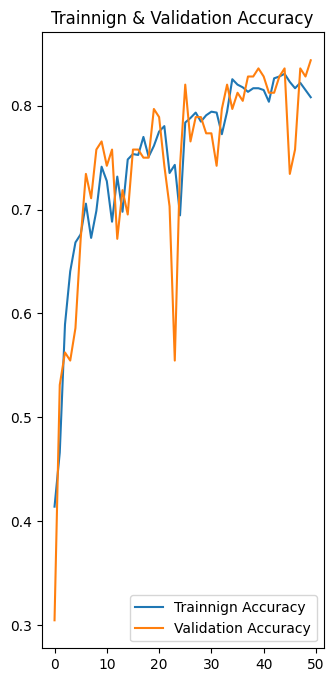

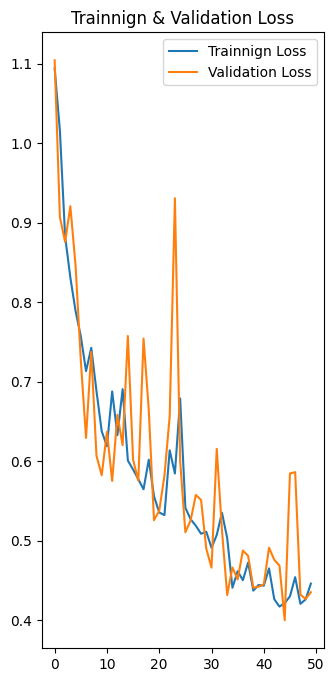

In [92]:

plt.figure(figsize = (8,8))
plt.subplot(1, 2, 1)
plt.plot(range(EPOCHS), accuracy, label = "Trainnign Accuracy")
plt.plot(range(EPOCHS), val_accuracy, label = "Validation Accuracy")
plt.legend(loc = 'lower right')
plt.title("Trainnign & Validation Accuracy")

plt.figure(figsize = (8,8))
plt.subplot(1, 2, 2)
plt.plot(range(EPOCHS), loss, label = "Trainnign Loss")
plt.plot(range(EPOCHS), val_loss, label = "Validation Loss")
plt.legend(loc = 'upper right')
plt.title("Trainnign & Validation Loss")
plt.show()

In [93]:
model.evaluate(test_data)

6/6 ━━━━━━━━━━━━━━━━━━━━ 2s 284ms/step - accuracy: 0.8321 - loss: 0.4820


[0.45494434237480164, 0.8333333134651184]

First image to predict
First image actual label:  Surface Erosion
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 341ms/step
Predicted Label:  Surface Erosion


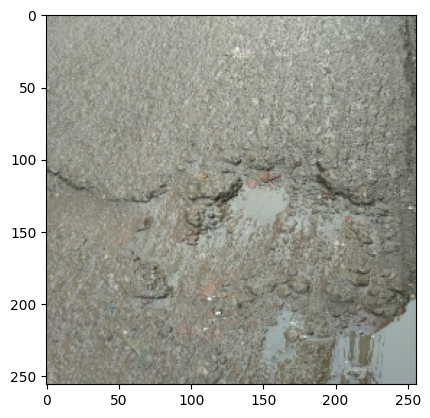

In [94]:
import numpy as np
for image_batch, label_batch in test_data.take(1):
    first_image = (image_batch[0].numpy().astype('uint8'))
    first_label = label_batch[0].numpy()
    
    print("First image to predict")
    plt.imshow(first_image)
    print("First image actual label: ", class_names[first_label])
    
    batch_prediction = model.predict(image_batch)
    print("Predicted Label: ",class_names[np.argmax(batch_prediction[0])])

In [95]:
def predict(model, img):
    # Expand image dims and predict
    img_array = tf.keras.preprocessing.image.img_to_array(img)
    img_array_expanded = tf.expand_dims(img_array, 0)
    prediction = model.predict(img_array_expanded, verbose=0)

    predicted_class = class_names[np.argmax(prediction[0])]
    confidence = round(100 * (np.max(prediction[0])), 2)

    # Lighting detection
    grayscale_img = tf.image.rgb_to_grayscale(img_array)
    brightness = tf.reduce_mean(grayscale_img).numpy()

    if brightness < 100:
        lighting = "Low light"
    elif brightness > 180:
        lighting = "High light"
    else:
        lighting = "Normal lighting"

    return predicted_class, confidence, lighting

In [1]:
plt.figure(figsize=(14, 15))
for images, labels in test_data.take(1):
    for i in range(9):
        ax = plt.subplot(3, 3, i + 1)
        img = images[i].numpy().astype("uint8")
        plt.imshow(img)

        predicted_class, confidence, lighting = predict(model, img)
        actual_class = class_names[labels[i]]
        print(f"Confidence:->{confidence} Light:-> {lighting}")
        plt.title(f"Actual: {actual_class}\nPredicted: {predicted_class}\nConfidence: {confidence}%\nLighting: {lighting}")
        plt.axis("off")

NameError: name 'plt' is not defined

In [97]:
confidence_threshold = 0.8
if confidence >= confidence_threshold:
    print(f"Prediction: {predicted_class}, Confidence: {confidence}")
else:
    print("Prediction confidence is too low.")


Prediction: Surface Erosion, Confidence: 49.130001068115234


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 348ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 331ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 297ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 310ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 264ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 304ms/step


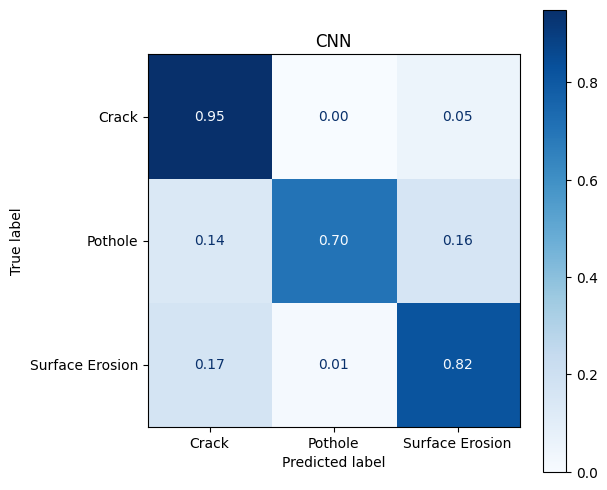

In [100]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

class_names = ['Crack', 'Pothole', 'Surface Erosion'] 
y_true = []
y_pred = []

for images, labels in test_data:
    predictions = model.predict(images)

    # If labels are integer-encoded (not one-hot)
    y_true.extend(labels.numpy())
    y_pred.extend(np.argmax(predictions, axis=1))

cm = confusion_matrix(y_true, y_pred)
cm_normalized = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
disp = ConfusionMatrixDisplay(confusion_matrix=cm_normalized, display_labels=class_names)
fig, ax = plt.subplots(figsize=(6, 6))
disp.plot(ax=ax, cmap=plt.cm.Blues, values_format=".2f")
plt.title("CNN")
plt.savefig("confusion_matrix_CNN.png", dpi=300, bbox_inches='tight')
plt.show()


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 269ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 315ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 320ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 347ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 306ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 341ms/step


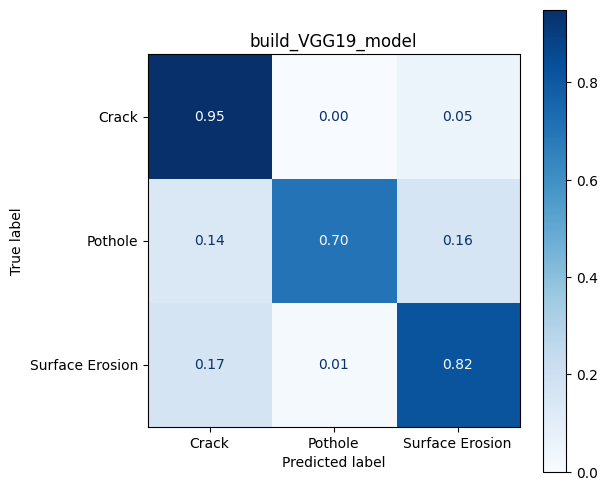

In [99]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

# Optional: define class names based on your dataset
class_names = ['Crack', 'Pothole', 'Surface Erosion']  # Update if you have different classes

# Step 1: Get true and predicted labels
y_true = []
y_pred = []

# Loop through test dataset
for images, labels in test_data:
    predictions = model.predict(images)
    
    # If labels are integer-encoded (not one-hot)
    y_true.extend(labels.numpy())
    y_pred.extend(np.argmax(predictions, axis=1))

# Step 2: Generate confusion matrix
cm = confusion_matrix(y_true, y_pred)

# Step 3: Normalize the confusion matrix (row-wise normalization)
cm_normalized = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]

# Step 4: Plot the normalized confusion matrix
disp = ConfusionMatrixDisplay(confusion_matrix=cm_normalized, display_labels=class_names)
fig, ax = plt.subplots(figsize=(6, 6))
disp.plot(ax=ax, cmap=plt.cm.Blues, values_format=".2f")  # 2 decimal places

# Step 5: Save and show the plot
plt.title("build_VGG19_model")
plt.savefig("confusion_matrix_normalized.png", dpi=300, bbox_inches='tight')
plt.show()
